In [1]:
# Here we try to use dendrogram to segment the houses and find metrics that matter
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist



In [2]:
df: pd.DataFrame = pd.read_csv("bigSet32000with_derrivatives.csv")

# These 4 variables are just enumerations of row
df.drop(['Unnamed: 0', 'Unnamed: 0.1.1', 'Unnamed: 0.2', 'Unnamed: 0.1', 'energiaKlass', 'EHR_Code']
                ,axis=1, inplace=True)
df = df[
    df['address'].str.contains("Mustamäe"
                               or "Lasnamäe"
                               or "Põhja-Tallinna"
                               or "Haabersti"
                               or "Kesklinna linnaosa")
]

data_types: dict = df.dtypes
for col_name, col_type in data_types.items():
    if np.issubdtype(object, col_type.type) :
        df.drop([col_name], axis=1, inplace=True)
    else:
        # data_frame[col_name].fillna(data_frame[col_name].mode(), inplace=True)
        df[col_name].fillna(round(df[col_name].mean(), 1), inplace=True)
df.to_csv(".\out.csv",index=False)

# Clustering and visualisation
After modeling the data we can now preform hierarchical clustering and show it on a dendrogram

Because I don't know which measurement metric or final cluster size to use my approach was
to try all measurements and sizes range(10, 21, 5) out with each other and see if there is a common pattern.


Some references I used for this code:

    - https://en.wikipedia.org/wiki/Cophenetic_correlation

     -fancy_dentogram function comes from: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

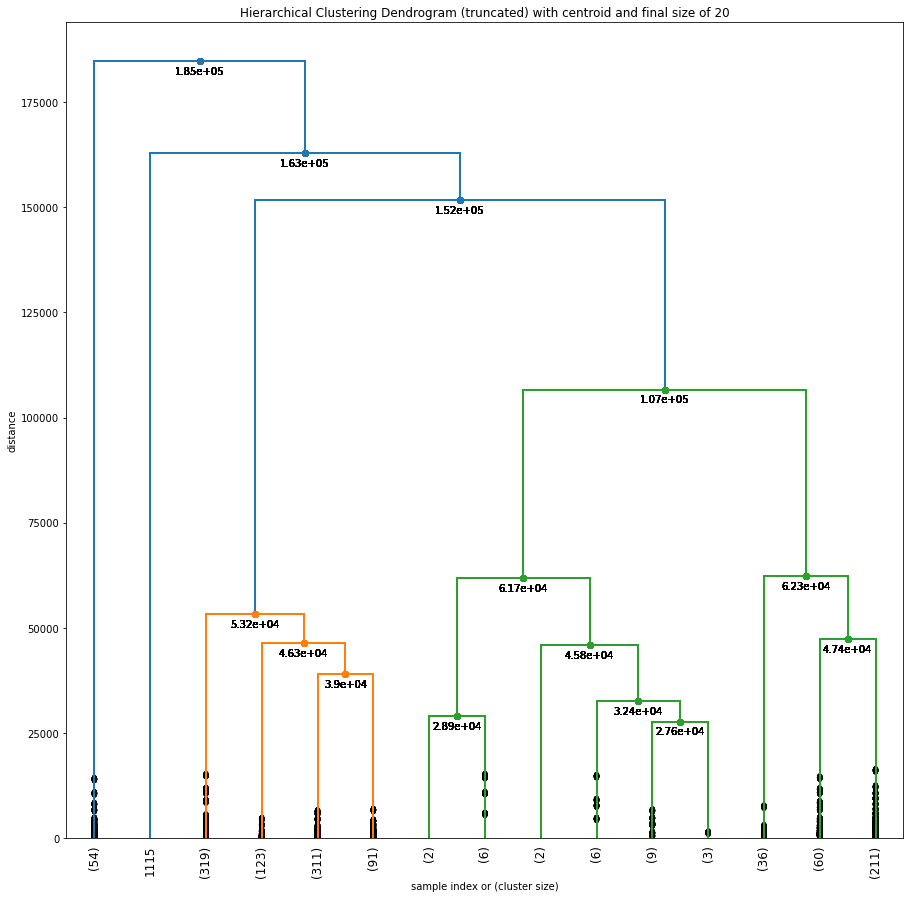

In [3]:

plt.subplots(figsize=(15,15))


def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):

        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

measurements: list = ["ward", "single", "complete", "average", "weighted", "centroid"]
final_clusters: list = [i for i in range(10, 21, 5)]

for measurment in measurements:
    links = linkage(df.to_numpy(), method='ward')
    c, coph_dists = cophenet(links, pdist(df.to_numpy()))
    for size in final_clusters:
        plt.title(f'Hierarchical Clustering Dendrogram (truncated) with {measurment} and final size of {size}')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        fancy_dendrogram(
            links,
            truncate_mode='lastp',
            p=15,
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True
        )